**Проект Телеком**

### Описание проекта

Заказчик проекта - оператор связи.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Цель проекта**: Создать модель, которая будет предсказывать отток клиентов, чтобы у оператора появилась возможность его предотвратить.  
**Задачи проекта:** Для достижения цели необходимо выполнить предобработку данных, создать модели нескольких типов, подобрать гиперпараметры, оценить модели, выбрать лучшую, провести финальное тестирование.

Импортируем необходимые для анализа библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

### Исследовательский анализ данных

Импортируем данные:

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

**Ознакомимся с таблицей, содержащей информацию о договорах:**

In [3]:
print(contract.info())
contract.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


Таблица содержит 7043 записи и 7 столбцов.  
По столбцам содержится следующая информация:  
- customerID - код клиента  
- BeginDate - дата заключения договора  
- EndDate - дата окончания договора  
- Type - тип оплаты услуг  
- PaperlessBilling - информация о предоставлении бумажной квитанции  
- PaymentMethod - способ оплаты
- MonthlyCharges - стоимость услуг в месяц  
- TotalCharges - общая стоимость услуг с момента заключения договора

Проверим таблицу на наличие дубликатов:

In [4]:
contract.duplicated().sum()

0

Дубликатов в таблице нет. Проверим на наличие пропусков:

In [5]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Пропусков в таблице нет. Приведем данные в столбцах к необходимым типам:

In [6]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [7]:
contract['TotalCharges'].isna().sum() / contract['TotalCharges'].count() * 100

0.15642775881683732

После приведения данных столбца TotalCharges к числовому типу в столбце образовались пропуски. Доля этих пропусков по отношению ко всему датасету равно 0.15%. Учитывая их малую долю, строки с этими пропусками можно удалить.

In [8]:
contract = contract.dropna()

Создадим столбец с целевым признаком на основе столбца EndDate - перестал клиент пользоваться услугами или нет.

In [9]:
def left_target(EndDate):
    if EndDate == 'No':
        return 0
    if EndDate != 'No':
        return 1
    
contract['Left'] = contract['EndDate'].apply(left_target)

Заменим значения No в столбце на дату выгрузки данных - 2020-02-01. Изменим тип данных в столбце.

In [10]:
contract['EndDate'] = contract['EndDate'].replace('No', '2020-02-01')
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

Создадим новый признак - посчитаем, сколько дней клиент пользуется услугами оператора.

In [11]:
contract['Duration'] = (contract['EndDate'] - contract['BeginDate']).dt.days

**Ознакомимся с таблицей, содержащей информацию о персональных данных клиента:**

In [12]:
print(personal.info())
personal.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


Таблица содержит 7043 записи и 5 столбцов.  
По столбцам содержится следующая информация:  
- customerID - код клиента  
- Gender - пол клиента
- SeniorCitizen - информация о том, является ли клиент пенсионером 
- Partner - информация о том, есть ли у клиента супруг/супруга  
- Dependents - информация о том, есть ли на попечении клиента иждивенцы  

Проверим таблицу на наличие дубликатов:

In [13]:
personal.duplicated().sum()

0

Дубликатов нет. Проверим таблицу на наличие пропусков:

In [14]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Объединим данные таблицы с таблицей contract:

In [15]:
data = contract.merge(personal, how='left', on='customerID')

**Ознакомимся с таблицей, содержащей информацию об интернет-услугах, предоставляемых клиенту:**

In [16]:
print(internet.info())
internet.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


Таблица содержит 5517 записей и 8 столбцов.  
По столбцам содержится следующая информация:  
- customerID - код клиента  
- InternetService - информация о том, какой тип подключения к интернету используется клиентом
- OnlineSecurity - информация о том, предоставляется ли клиенту услуга блокировки небезопасных сайтов
- OnlineBackup - информация о том, предоставляется ли клиенту услуга облачного хранения файлов
- DeviceProtection - информация о том, предоставляется ли клиенту услуга антивируса
- TechSupport - информация о том, предоставляется ли клиенту услуга выделенной линии технической поддержки
- StreamingTV - информация о том, предоставляется ли клиенту услуга стримингового телевидения
- StreamingMovies - информация о том, предоставляется ли клиенту услуга каталога фильмов

Проверим таблицу на наличие дубликатов:

In [17]:
internet.duplicated().sum()

0

Дубликатов нет. Проверим таблицу на наличие пропусков:

In [18]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Создадим новый признак - использование услуги интернет:

In [19]:
internet['internet'] = 'Yes'

Объединим полученную таблицу с общей таблицей для создания модели:

In [20]:
data = data.merge(internet, how='left', on='customerID')

In [21]:
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Left                   0
Duration               0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
internet            1520
dtype: int64

В столбцах образовались пропуски в строках пользователей, которые не пользуются услугами интернета. Заполним пропуски:

In [22]:
data = data.fillna('No')

**Ознакомимся с таблицей, содержащей информацию об услугах телефонии, предоставляемых клиенту:**

In [23]:
print(phone.info())
phone.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


Таблица содержит 6361 запись и 2 столбца.  
По столбцам содержится следующая информация:  
- customerID - код клиента  
- MultipleLines - информация о том, предоставляется ли клиенту услуга подключения телефонного аппарата к нескольким линиям одновременно

Проверим таблицу на наличие дубликатов:

In [24]:
phone.duplicated().sum()

0

Дубликатов нет. Проверим таблицу на наличие пропусков:

In [25]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

Добавим новый признак - использование услуг телефонии:

In [26]:
phone['phone'] = 'Yes'

Объединим полученную таблицу с общей таблицей для создания модели:

In [27]:
data = data.merge(phone, how='left', on='customerID')

In [28]:
data.isna().sum()

customerID            0
BeginDate             0
EndDate               0
Type                  0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Left                  0
Duration              0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
internet              0
MultipleLines       680
phone               680
dtype: int64

В таблице образовались пропуски в строках клиентов, которые не пользуются услугами телефонии. Заполним пропуски:

In [29]:
data = data.fillna('No')

Составлена сводная таблица для построения модели.

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Left              7032 non-null   int64         
 9   Duration          7032 non-null   int64         
 10  gender            7032 non-null   object        
 11  SeniorCitizen     7032 non-null   int64         
 12  Partner           7032 non-null   object        
 13  Dependents        7032 non-null   object        
 14  InternetService   7032 n

Проверим как разные признаки влияют на отток клиентов и какие признаки стоит оставить для обучения модели:

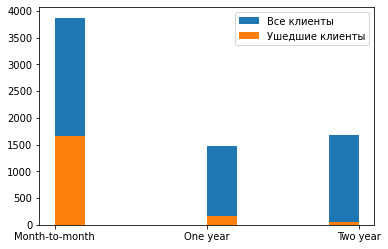

In [31]:
fig, ax = plt.subplots()
ax.hist(data['Type'], label='Все клиенты')
ax.hist(data[data['Left']==1]['Type'], label='Ушедшие клиенты')
ax.legend()

По данному графику видно, что почти все ушедшие клиенты использовали помесячную плату.Среди клиентов, использовавших договоры сроком на 1 и 2 года практически нет ушедших. Таким образом, тип договора - важный фактор, влияющий на отток.

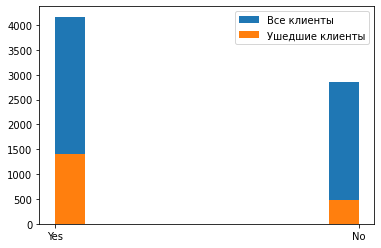

In [32]:
fig, ax = plt.subplots()
ax.hist(data['PaperlessBilling'], label='Все клиенты')
ax.hist(data[data['Left']==1]['PaperlessBilling'], label='Ушедшие клиенты')
ax.legend()

Доля ушедших клиентов среди клиентов, использовавших электронный чек больше, чем доля ушедших среди тех, кто использовал бумажный. Данный признак тоже важен для модели.

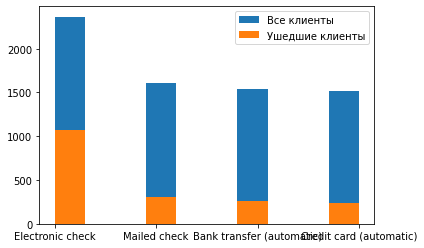

In [33]:
fig, ax = plt.subplots()
ax.hist(data['PaymentMethod'], label='Все клиенты')
ax.hist(data[data['Left']==1]['PaymentMethod'], label='Ушедшие клиенты')
ax.legend()

Доля ушедших клиентов среди разных типов оплаты тоже отличается. Оставим данный признак.

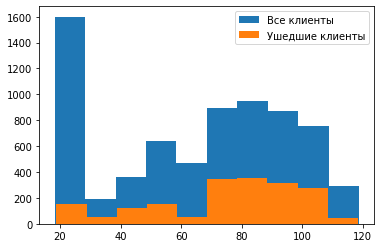

In [34]:
fig, ax = plt.subplots()
ax.hist(data['MonthlyCharges'], label='Все клиенты')
ax.hist(data[data['Left']==1]['MonthlyCharges'], label='Ушедшие клиенты')
ax.legend()

По данному графику видно, что доля ушедших клиентов меняется с ростом стоимости услуг в месяц.Оставим данный признак.

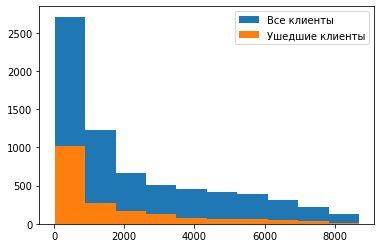

In [35]:
fig, ax = plt.subplots()
ax.hist(data['TotalCharges'], label='Все клиенты')
ax.hist(data[data['Left']==1]['TotalCharges'], label='Ушедшие клиенты')
ax.legend()

Данный график показывает, что доля ушедших клиенток не меняется с возрастанием стоимости. Данный признак можно не использовать для обучения модели.

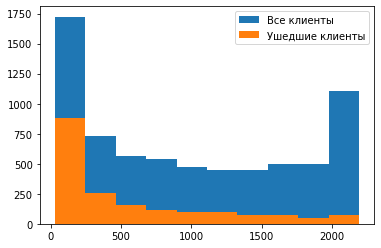

In [36]:
fig, ax = plt.subplots()
ax.hist(data['Duration'], label='Все клиенты')
ax.hist(data[data['Left']==1]['Duration'], label='Ушедшие клиенты')
ax.legend()

По данному графику видно, что доля ушедших клиентов среди клиентов, использующих услуги оператора долгое время, сильно меньше, чем доля ушедших среди тех, кто недолго пользовался услугами. Это важный признак.

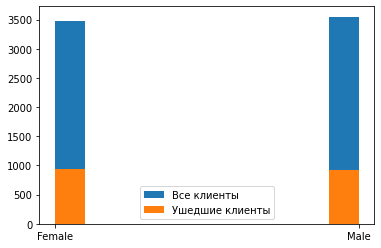

In [37]:
fig, ax = plt.subplots()
ax.hist(data['gender'], label='Все клиенты')
ax.hist(data[data['Left']==1]['gender'], label='Ушедшие клиенты')
ax.legend()

По данному графику видно, что пол клиента не влияет на отток. Данный признак можно удалить.

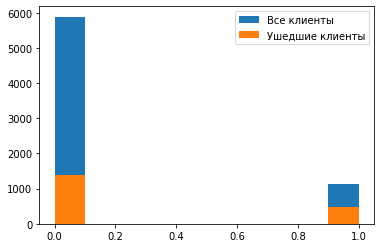

In [38]:
fig, ax = plt.subplots()
ax.hist(data['SeniorCitizen'], label='Все клиенты')
ax.hist(data[data['Left']==1]['SeniorCitizen'], label='Ушедшие клиенты')
ax.legend()

Доля ушедших клиентов среди клиентов, являющихся пенсионерами по возрасту,сильно больше, чем среди клиентов, не являющихся пенсионерами по возрасту. Это важный признак.

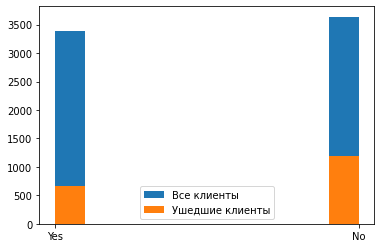

In [39]:
fig, ax = plt.subplots()
ax.hist(data['Partner'], label='Все клиенты')
ax.hist(data[data['Left']==1]['Partner'], label='Ушедшие клиенты')
ax.legend()

Доля ушедших клиентов среди женатых/замужних и холостых отличается. Оставим данный признак.

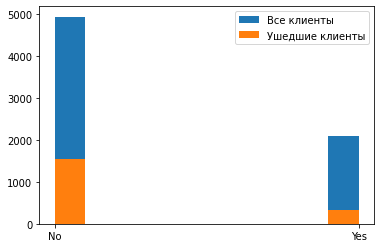

In [40]:
fig, ax = plt.subplots()
ax.hist(data['Dependents'], label='Все клиенты')
ax.hist(data[data['Left']==1]['Dependents'], label='Ушедшие клиенты')
ax.legend()

Доля ушедших клиентов среди тех, у кого на попечении имеются иждевенцы и среди тех, у кого нет, отличается. Оставим данный признак.

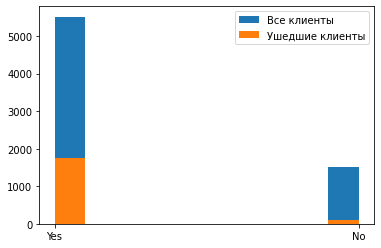

In [41]:
fig, ax = plt.subplots()
ax.hist(data['internet'], label='Все клиенты')
ax.hist(data[data['Left']==1]['internet'], label='Ушедшие клиенты')
ax.legend()

По данному признаку видно, что доля ушедших клиентов среди тех, кто пользуется услугами интернета, сильно больше, чем среди тех, кто использует только услуги телефонии. Это важный признак.

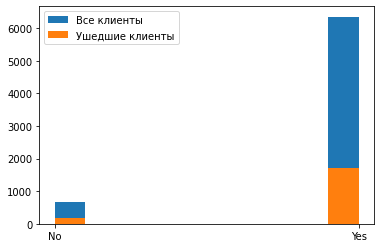

In [42]:
fig, ax = plt.subplots()
ax.hist(data['phone'], label='Все клиенты')
ax.hist(data[data['Left']==1]['phone'], label='Ушедшие клиенты')
ax.legend()

Доля ушедших клиентов среди тех, кто использует услуги телефонии и тех, кто не использует, отличается незначительно, данный признак можно удалить.

Посмотрим детально, использование каких услуг влияет на отток:

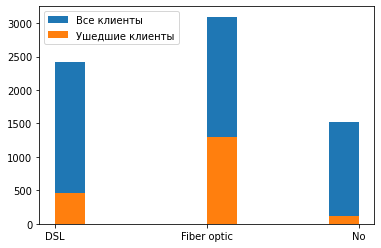

In [43]:
fig, ax = plt.subplots()
ax.hist(data['InternetService'], label='Все клиенты')
ax.hist(data[data['Left']==1]['InternetService'], label='Ушедшие клиенты')
ax.legend()

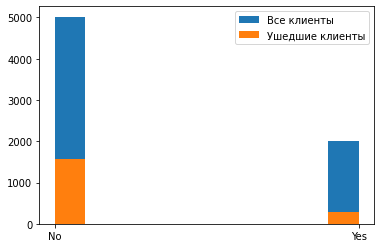

In [44]:
fig, ax = plt.subplots()
ax.hist(data['OnlineSecurity'], label='Все клиенты')
ax.hist(data[data['Left']==1]['OnlineSecurity'], label='Ушедшие клиенты')
ax.legend()

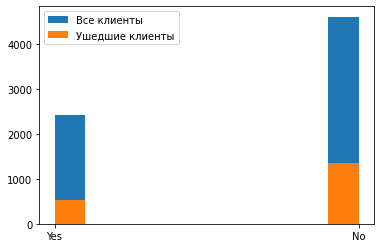

In [45]:
fig, ax = plt.subplots()
ax.hist(data['OnlineBackup'], label='Все клиенты')
ax.hist(data[data['Left']==1]['OnlineBackup'], label='Ушедшие клиенты')
ax.legend()

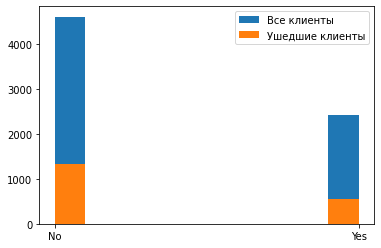

In [46]:
fig, ax = plt.subplots()
ax.hist(data['DeviceProtection'], label='Все клиенты')
ax.hist(data[data['Left']==1]['DeviceProtection'], label='Ушедшие клиенты')
ax.legend()

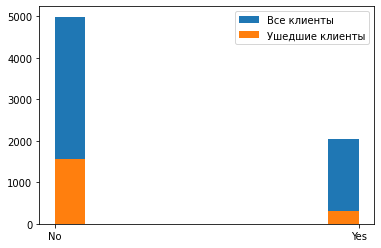

In [47]:
fig, ax = plt.subplots()
ax.hist(data['TechSupport'], label='Все клиенты')
ax.hist(data[data['Left']==1]['TechSupport'], label='Ушедшие клиенты')
ax.legend()

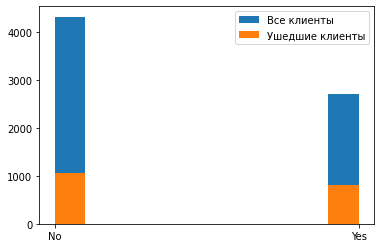

In [48]:
fig, ax = plt.subplots()
ax.hist(data['StreamingTV'], label='Все клиенты')
ax.hist(data[data['Left']==1]['StreamingTV'], label='Ушедшие клиенты')
ax.legend()

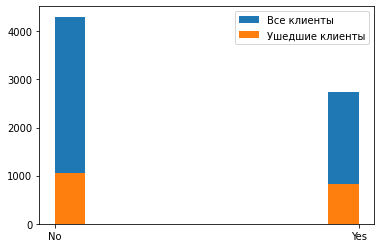

In [49]:
fig, ax = plt.subplots()
ax.hist(data['StreamingMovies'], label='Все клиенты')
ax.hist(data[data['Left']==1]['StreamingMovies'], label='Ушедшие клиенты')
ax.legend()

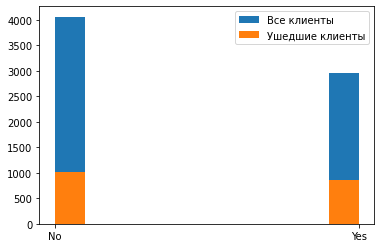

In [50]:
fig, ax = plt.subplots()
ax.hist(data['MultipleLines'], label='Все клиенты')
ax.hist(data[data['Left']==1]['MultipleLines'], label='Ушедшие клиенты')
ax.legend()

По данным графикам можно выделить услуги, использование которых влияет на отток: InternetService, OnlineSecurity, StreamingTV, StreamingMovies, MultipleLines. Остальные признаки можно удалить.

Удалим из таблицы для обучения модели признаки, не влияющие на отток клиентов:

In [51]:
data = data.drop(['customerID', 'BeginDate', 'EndDate', 'gender', 'TotalCharges', 'phone', 'OnlineBackup', 'DeviceProtection', 
                 'TechSupport'], axis=1)

Таблица для создания модели готова. 

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   Left              7032 non-null   int64  
 5   Duration          7032 non-null   int64  
 6   SeniorCitizen     7032 non-null   int64  
 7   Partner           7032 non-null   object 
 8   Dependents        7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  StreamingTV       7032 non-null   object 
 12  StreamingMovies   7032 non-null   object 
 13  internet          7032 non-null   object 
 14  MultipleLines     7032 non-null   object 
dtypes: float64(1), int64(3), object(11)
memory usage: 879.0+ KB


Выделим признаки и целевой признак в данных:

In [53]:
features = data.drop('Left', axis=1)
target = data['Left']

Разделим данные на обучающую и тестовую выборки:

In [54]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                        test_size=0.25, random_state=281122, 
                                                                           stratify=target)

In [55]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 6467 to 4343
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5274 non-null   object 
 1   PaperlessBilling  5274 non-null   object 
 2   PaymentMethod     5274 non-null   object 
 3   MonthlyCharges    5274 non-null   float64
 4   Duration          5274 non-null   int64  
 5   SeniorCitizen     5274 non-null   int64  
 6   Partner           5274 non-null   object 
 7   Dependents        5274 non-null   object 
 8   InternetService   5274 non-null   object 
 9   OnlineSecurity    5274 non-null   object 
 10  StreamingTV       5274 non-null   object 
 11  StreamingMovies   5274 non-null   object 
 12  internet          5274 non-null   object 
 13  MultipleLines     5274 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 618.0+ KB


In [56]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 6467 to 4343
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5274 non-null   object 
 1   PaperlessBilling  5274 non-null   object 
 2   PaymentMethod     5274 non-null   object 
 3   MonthlyCharges    5274 non-null   float64
 4   Duration          5274 non-null   int64  
 5   SeniorCitizen     5274 non-null   int64  
 6   Partner           5274 non-null   object 
 7   Dependents        5274 non-null   object 
 8   InternetService   5274 non-null   object 
 9   OnlineSecurity    5274 non-null   object 
 10  StreamingTV       5274 non-null   object 
 11  StreamingMovies   5274 non-null   object 
 12  internet          5274 non-null   object 
 13  MultipleLines     5274 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 618.0+ KB


Закодируем категориальные признаки:

In [57]:
cat_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Partner', 'Dependents', 'internet']
enc = OneHotEncoder(handle_unknown='ignore')

features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

features_train_ohe = enc.fit_transform(features_train[cat_columns])
features_test_ohe = enc.transform(features_test[cat_columns])

### Построение модели

Проверим данные на дисбаланс классов:

In [58]:
print(data[data['Left'] == 1]['Left'].count())
print(data[data['Left'] == 0]['Left'].count())

data[data['Left'] == 0]['Left'].count() / data[data['Left'] == 1]['Left'].count()

1869
5163


2.7624398073836276

В имеющихся данных сильный дисбаланс классов. Клиентов, которые ушли, почти в 3 раза меньше, чем клиентов, которые остались. Этот дисбаланс необходимо будет учеть при создании моделей.

In [59]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 6467 to 4343
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5274 non-null   object 
 1   PaperlessBilling  5274 non-null   object 
 2   PaymentMethod     5274 non-null   object 
 3   MonthlyCharges    5274 non-null   float64
 4   Duration          5274 non-null   int64  
 5   SeniorCitizen     5274 non-null   int64  
 6   Partner           5274 non-null   object 
 7   Dependents        5274 non-null   object 
 8   InternetService   5274 non-null   object 
 9   OnlineSecurity    5274 non-null   object 
 10  StreamingTV       5274 non-null   object 
 11  StreamingMovies   5274 non-null   object 
 12  internet          5274 non-null   object 
 13  MultipleLines     5274 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 618.0+ KB


**Построим модель логистической регрессии и проверим ее качество кросс-валидацией:**

In [60]:
random = 281122

In [61]:
%%time
log_reg = LogisticRegression(random_state=random)
roc_auc_log_reg = cross_val_score(log_reg, features_train_ohe, target_train, 
                                  scoring='roc_auc', cv=5).mean()
acc_log_reg = cross_val_score(log_reg, features_train_ohe, target_train, 
                              scoring='accuracy', cv=5).mean()
print('auc_roc модели логистической регрессии:', roc_auc_log_reg)
print('accuracy модели логистической регрессии:', acc_log_reg)

auc_roc модели логистической регрессии: 0.804538298568033
accuracy модели логистической регрессии: 0.7645062366790472
CPU times: user 271 ms, sys: 7.56 ms, total: 278 ms
Wall time: 277 ms


Модель логистической регрессии показала на кросс-валидации значение auc_roc = 0.8, accuracy = 0.76.

**Построим модель древа решений и подберем наилучшие параметры, проверим качество модели, измерим время обучения модели:**

In [62]:
%%time
DTC = DecisionTreeClassifier(random_state=random)
GSCV = GridSearchCV(DTC, {'max_depth': list(range(1, 20))}, cv=5, scoring='roc_auc')
GSCV.fit(features_train_ohe, target_train)
roc_auc_DTC = GSCV.best_score_

print('Лучшая глубина древа:', GSCV.best_estimator_)
print('auc_roc модели:', roc_auc_DTC)

Лучшая глубина древа: DecisionTreeClassifier(max_depth=6, random_state=281122)
auc_roc модели: 0.79561921350741
CPU times: user 989 ms, sys: 12.7 ms, total: 1 s
Wall time: 1.01 s


Лучшая глубина древа - 6. Модель древа решений с такими параметрами показала результат auc_roc = 0.8.

**Построим модель случайного леса и подберем наилучшие параметры:**

In [63]:
# %%time
# RFC = RandomForestClassifier(random_state=random)
# GSCV = GridSearchCV(RFC, {'max_depth': list(range(1, 20)), 'n_estimators': list(range(1, 20))}, cv=5, 
#                           scoring='roc_auc')
# GSCV.fit(features_train_ohe, target_train)
# roc_auc_RFC = GSCV.best_score_
# print('Лучшие параметры случайного леса:', GSCV.best_params_)
# print('auc_roc модели:', roc_auc_RFC)

Лучшая глубина древа для случайного леса - 5, количество деревьев - 16. Модель случайного леса с такими параметрами показала результат auc_roc = 0.80.

**Построим модель градиентного бустинга:**

In [64]:
# %%time
# GBM = lgb.LGBMClassifier(random_state=random)
# parameters = {
#     'learning_rate': [0.01, 0.1, 1],
#     'n_estimators': [20, 40]
# }
# GSCV = GridSearchCV(GBM, parameters, scoring='roc_auc')
# GSCV.fit(features_train_ohe, target_train)
# roc_auc_GBM = GSCV.best_score_
# print('Лучшие параметры градиентного бустинга:', GSCV.best_params_)
# print('auc_roc:', roc_auc_GBM)

Лучшие параметры градиентного бустинга: learning_rate = 0.1, n_estimators = 20.
Модель градиентного бустинга с такими параметрами показала результат auc_roc = 0.8.

**Построим модель catboost, подберем лучшие гиперпараметры:**

In [65]:
cat_features = list([0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13])
cat_features

[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13]

In [66]:
# %%time
# catboost = CatBoostClassifier(loss_function='Logloss', random_seed=random, silent=True)

# catboost_params = {
#  'depth': [x for x in range(1,5)],
#  'iterations': [x for x in range(100,1100, 100)],
#  'learning_rate': [0.5, 0.6, 0.7],
#  'l2_leaf_reg':[x for x in range(1,7)],
#   'cat_features':[cat_features]
#  }



# grid_search_catboost = GridSearchCV(catboost,
#                                    catboost_params, 
#                                    cv=5,
#                                    n_jobs=-1,
#                                    scoring='roc_auc')


# grid_search_catboost.fit(features_train, target_train)
# grid_search_catboost.best_score_
# grid_search_catboost.best_params_

Вывод кода:  
CPU times: user 1h 39min 29s, sys: 5min 20s, total: 1h 44min 49s  
Wall time: 2h 17min 57s  
{'cat_features': [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13],  
 'depth': 2,  
 'iterations': 500,  
 'l2_leaf_reg': 1,  
 'learning_rate': 0.6}  
 


Проверим качество модели с выбранными гиперпараметрами:

In [67]:
catboost = CatBoostClassifier(loss_function='Logloss', random_seed=random, silent=True)

catboost_params = {
 'depth': [2],
 'iterations': [500],
 'l2_leaf_reg':[1],
 'learning_rate': [0.6],
  'cat_features':[cat_features]
    
}



grid_search_catboost = GridSearchCV(catboost,
                                   catboost_params, 
                                   verbose=3,
                                   cv=5,
                                   n_jobs=-1,
                                   scoring='roc_auc')


grid_search_catboost.fit(features_train, target_train)
grid_search_catboost.best_score_


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13], depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.6; total time=   2.4s
[CV 2/5] END cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13], depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.6; total time=   2.5s
[CV 3/5] END cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13], depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.6; total time=   2.3s
[CV 4/5] END cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13], depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.6; total time=   2.4s
[CV 5/5] END cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13], depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.6; total time=   2.4s


0.9387744677208957

Для модели катбуста были подобраны параметры: cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13], depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.6.  
Модель с такими параметрами показала результат auc_roc = 0.94.

### Выбор и тестирование модели

Сравним полученные модели:

In [68]:
models = pd.DataFrame({'model': ['Logistic Regression', 
                                 'Decision Tree Classifier (max_depth=6)', 
                                 'Random Forest Classifier (n_est=16, max_depth=5)', 
                                'LGBM Classifier (learning_rate=0.1, n_est=20)', 
                                'CatBoost Classifier (cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13], depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.6)'], 
                       'auc_roc' : [0.8, 0.8, 0.8, 0.8, 0.93]})

In [69]:
models

,model,auc_roc
0,Logistic Regression,0.80
1,Decision Tree Classifier (max_depth=6),0.80
2,"Random Forest Classifier (n_est=16, max_depth=5)",0.80
3,"LGBM Classifier (learning_rate=0.1, n_est=20)",0.80
4,"CatBoost Classifier (cat_features=[0, 1, 2, 6,...",0.93


Лучший результат показала модель CatBoost Classifier с параметрами cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13], depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.6.  
Проверим данную модель на тестовой выборке:

In [70]:
model_catboost = CatBoostClassifier(loss_function='Logloss', random_seed=random, silent=True,
                                    depth=2, iterations=500, learning_rate=0.6, l2_leaf_reg=1,  
                                    cat_features=cat_features)
model_catboost.fit(features_train, target_train)
roc_auc_test_catboost = roc_auc_score(target_test, model_catboost.predict_proba(features_test)[:, 1])
print(roc_auc_test_catboost)

0.9461923015042369


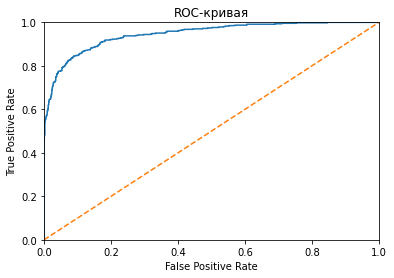

In [71]:
fpr, tpr, thresholds = roc_curve(target_test, model_catboost.predict_proba(features_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

На тестовой выборке модель также показала отличный результат auc_roc = 0.95.

Проверим значение accuracy выбранной модели на тестовой выборке:

In [72]:
score = accuracy_score(target_test, model_catboost.predict(features_test))
print(score)

0.90386803185438


Значение accuracy модели на тестовой выборке - 0.9.

Построим матрицу ошибок:

In [73]:
print(confusion_matrix(target_test, model_catboost.predict(features_test)))

[[1247   44]
 [ 125  342]]


Text(0.5, 1.05, 'Матрица ошибок')

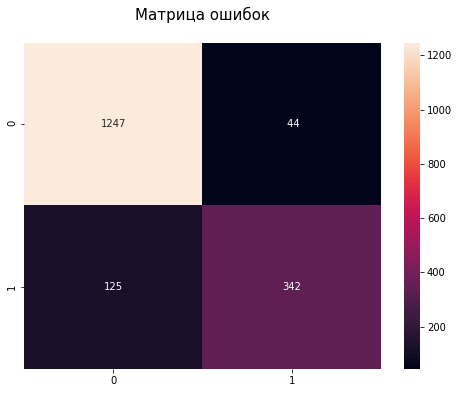

In [74]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(target_test, model_catboost.predict(features_test)),annot=True, 
            fmt='3.0f')
plt.title('Матрица ошибок', y=1.05, size=15)


По данной матрице видно, что модель ошибалась редко.

Посмотрим на важность признаков для выбранной модели:

In [75]:
pd.DataFrame(model_catboost.get_feature_importance(), index=data.drop(['Left'], axis=1).dtypes.index, 
             columns=['Feature importance'])\
.sort_values(by='Feature importance', ascending = False)

,Feature importance
Duration,82.607238
MonthlyCharges,5.360470
internet,4.117088
InternetService,2.383816
Type,2.241780
PaymentMethod,0.844424
OnlineSecurity,0.839236
StreamingMovies,0.392586
MultipleLines,0.332845
PaperlessBilling,0.268058


Text(0.5, 1.0, 'Feature Importance')

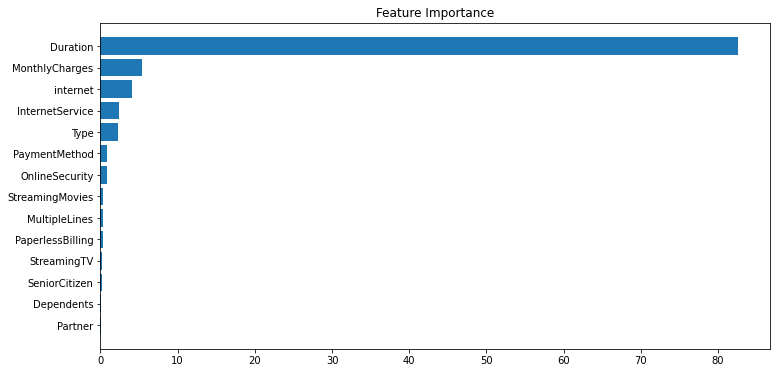

In [77]:
feature_importance = model_catboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')


Самым важным признаком для модели Catboost стало число дней договора. Также влияние оказали такие признаки, как стоимость услуг в месяц, использование услуг интернета, тип подключения и тип договора. Влияние остальных признаков на модель оказалось минимально.

### Вывод

В ходе исследования были проанализированы данные оператора связи и создана модель, предсказывающая отток клиентов. 
- Были проанализированы предоставленные компанией данные, выбраны признаки для построения моделей. 
- Было создано 5 моделей разных типов, подобраны параметры. 
- Исходя из сравнения модеелй по значению auc-roc была выбрана модель CatBoost со следующими параметрами: cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13], depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.6. 
- На финальном тестировании данная модель показала результат auc_roc = 0.95, accuracy = 0.9. 
- Были проанализированы признаки, оказывающие большее влияние на данную модель. Главным по важности стал признак Duration - число дней использования услуг клиентом.

### Отчет

**В ходе работы над проектом были выполнены следующие пункты плана:**  
  
**1. Исследовательский анализ данных:**  
  
- данные были импортированы, описаны;
- все таблицы были проверены на наличие дубликатов и пропусков; 
- данные были приведены к необходимым типам;
- были созданы дополнительные признаки: Left - целевой признак - отказался ли клиент от услуг оператора, Duration - срок действия договора;
- предоставленные данные были объединены в сводную таблицу для дальнейшего анализа и создания модели;
- при помощи графиков было проанализировано распределение признаков между ушедшими и не ушедшими клиентами;
- были определены признаки, влиящие на отток клиентов;
- признаки, не влияющие на отток, были удалены из сводной таблицы;
- полученная таблица была разделена на признаки и целевой признак;
- данные были разделены на обучающую и тестовую выборки;
- категориальные признаки были закодированы для создания моделей.
  
**2. Построение модели:**
  
- была создана модель логистической регрессии. Кросс-валидацией на тренировочной выборке было получено значение auc_roc = 0.8;
- была создана модель древа решений. С помощью GridSearchCV была определена лучшая глубина древа - 6 и получено значение auc_roc = 0.8;
- была создана модель случайного леса. С помощью GridSearchCV была определена лучшая глубина древа - 5 и лучшее количество деревьев - 16, получено значение auc_roc = 0.8;
- была создана модель LGBM. С помощью GridSearchCV были определены лучшие параметры для такой модели: learning_rate = 0.1, n_estimators = 20 и получено значение auc_roc = 0.8;
- была создана модель CatBoost. С помощью GridSearchCV были определены лучшие параметры для такой модели: cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13], depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.6 и получено значение auc_roc = 0.93.
- было проведено сравнение полученных моделей по значению auc_roc;
- в результате сравнения была выбрана лучшая модель - модель CatBoost с параметрами: cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13], depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.6.  

**3. Финальное тестирование:**
  
- выбранная модель (CatBoost с параметрами cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13], depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.6) была проверена на тестовой выборке;
- в ходе тестирования были проверены такие показатели как auc_roc и accuracy;
- были получены результаты auc_roc = 0.95, accuracy = 0.9;
- была построена матрица ошибок, продемонстрировавшая высокое качество модели;
- была проанализирована важность признаков для выбранной модели;
- был определен самый важный признак - срок действия договора - 'Duration'.

**Таким образом, все пункты плана были выполнены.**

***В ходе работы над проектом возникли следующие трудности:***  
- выбор момента и способа кодирования категориальных признаков;
- выбор способа определения важности признаков для создания модели;
- определение признаков, необходимых для создания модели;
- кодирование категориальных при помощи OneHotEncoder;
- достижение высокой метрики модели CatBoost;
- выбор способа получения предсказания при использовании модели CatBoost.

***Все возникшие трудности были преодолены с помощью рекомендаций ревьюера и самостоятельного поиска дополнительной информации.***

**При решении задачи были выделены следующие ключевые шаги:**
1. Предобработка данных
2. Создание нескольких моделей разных типов
3. Сравнение полученных моделей
4. Финальное тестирование выбранной модели
5. Выводы по результатам финального тестирования.

**Итоговая модель**

**В ходе прокта была создана модель, предсказывающая отток клиентов.**  
Тип модели - CatBoostClassifier.  
  
Параметры модели:  
      - cat_features=[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13];  
      - depth=2;  
      - iterations=500;  
      - l2_leaf_reg=1;   
      - learning_rate=0.6.  
  
Значение auc_roc модели на тестовой выборке = 0.95.
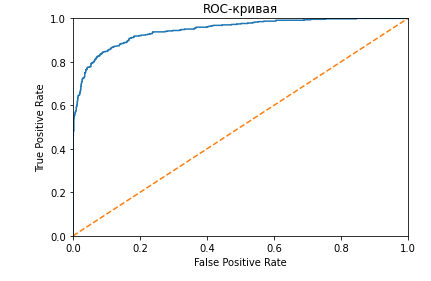
  
Значение accuracy модели на тестовой выборке = 0.93.
  
Матрица ошибок модели:  
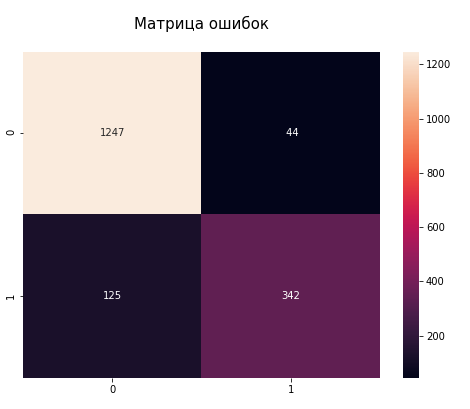  
  
Степень важности признаков для выбранной модели:  
  
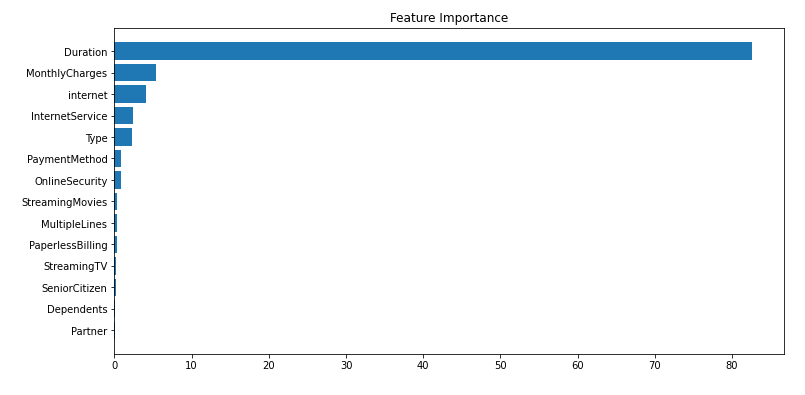

**Таким образом, в ходе работы над проектом была создана модель высокого качества для предсказания оттока клиентов.**